# Step 1: Read sample transcript

A sample meeting transcript is available here: [sample-meeting-transcript.txt](https://github.com/spackows/CASCON-2021_AI_ethics/blob/main/sample-meeting-transcript.txt)

In this step, read the sample transcript file into an array of lines of text.

In [62]:
import urllib.request
import re

def readSampleTranscript( url ):
    data_b = urllib.request.urlopen( url )
    lines_arr = []
    for line_b in data_b:
        line = line_b.decode( "utf8" ).strip()
        if re.match( "\S", line ):
            lines_arr.append( line )
    return lines_arr

In [64]:
file_url = "https://raw.githubusercontent.com/spackows/CASCON-2021_AI_ethics/main/sample-meeting-transcript.txt"
transcript_lines_arr = readSampleTranscript( file_url )
print( "\n".join( transcript_lines_arr[0:10] ) )

Sarah Packowski's Personal Room
2:00 pm - 2:17 pm  Friday, November 12, 2021 | (UTC-05:00) Eastern Time (US & Canada)
Richard Walls (IBM)  Sarah Packowski (IBM)  HEATHER Hagerty (IBM)  Sara Elsharawy (IBM)
WEBVTT
1
Sarah Packowski 00:00:33.444 --> 00:00:53.394
Okay, thanks everybody for joining me for this short meeting. What I wanted to do today was to go around the room and ask people to share. What is their favourite animal and why? So who wants to go? 1st.
2
HEATHER Hagerty 00:00:56.634 --> 00:00:57.714
I can go 1st.


# Step 2: List participants

The second line of the transcript lists the names of all meeting participants.

In this step, read the names of all meeting participants.

In [73]:
def allNames( line ):
    all_names_arr = []
    matches_arr = re.compile( r"\s{2,}" ).split( line )
    for match in matches_arr:
        name = re.sub( r"\s\(.*$", "", str( match ) )
        all_names_arr.append( name )
    return all_names_arr    

In [74]:
import json
all_names_arr = allNames( transcript_lines_arr[2] )
print( json.dumps( all_names_arr, indent=3 ) )

[
   "Richard Walls",
   "Sarah Packowski",
   "HEATHER Hagerty",
   "Sara Elsharawy"
]


# Step 3: Collect participants' speaking time

The transcript contains speaker names and transcript timings in lines like this:
```
Sarah Packowski 00:00:33.444 --> 00:00:53.394
```

In this step, read the transcript line by line, adding up the time each participant spends speaking.

In [69]:
def getTimings( lines_arr ):
    timings = {}
    for line in lines_arr:
        regex = re.compile( r"^\s*(?P<name>.*)\s+(?P<h1>\d{2})\:(?P<m1>\d{2})\:(?P<s1>\d{2})\.\d{3}\s\-\-\>\s(?P<h2>\d{2})\:(?P<m2>\d{2})\:(?P<s2>\d{2})\.\d{3}\s*$" )
        matches = regex.match( line )
        if matches:
            if( matches.group("name") not in timings ):
                timings[ matches.group("name") ] = 0
            timings[ matches.group("name") ] += getSeconds( matches )
    return timings

def getSeconds( matches ):
    t1 = ( int( matches.group("h1") ) * 60 * 60 ) + ( int( matches.group("m1") ) * 60 ) + int( matches.group("s1") )
    t2 = ( int( matches.group("h2") ) * 60 * 60 ) + ( int( matches.group("m2") ) * 60 ) + int( matches.group("s2") )
    return t2 - t1

In [72]:
timings_json = getTimings( transcript_lines_arr )
print( json.dumps( timings_json, indent=3 ) )

{
   "Sarah Packowski": 151,
   "HEATHER Hagerty": 167,
   "Sara Elsharawy": 59,
   "Richard Walls": 29
}


# Step 4: Normalize timings

Normalize timings to get percentage of total time instead of raw values.

In [75]:
def normalizeTimings( timings_json ):
    total_time = 0
    for name in timings_json:
        total_time += timings_json[ name ]
    for name in timings_json:
        percent = round( ( 100 * timings_json[ name ] ) / total_time )
        timings_json[ name ] = percent
    return timings_json

In [76]:
norm_timings_json = normalizeTimings( timings_json )
print( json.dumps( norm_timings_json, indent=3 ) )

{
   "Sarah Packowski": 37,
   "HEATHER Hagerty": 41,
   "Sara Elsharawy": 15,
   "Richard Walls": 7
}


# Step 5: Convert timings array to OrderedDict

We can use an OrderedDict structure to order results by time speaking.

In this step, create timings in an OrderedDict.

In [85]:
from collections import OrderedDict

def createOrderedDicionary( all_timings_json ):
    all_timings_dict = dict( [ (k,v) for k,v in all_timings_json.items() ] )
    ordered_all_timings_dict = OrderedDict( sorted( all_timings_dict.items(), key=lambda x:x[1] ) )
    return ordered_all_timings_dict

In [86]:
timings_ordered_dictionary = createOrderedDicionary( norm_timings_json )
print( json.dumps( timings_ordered_dictionary, indent=3 ) )

{
   "Richard Walls": 7,
   "Sara Elsharawy": 15,
   "Sarah Packowski": 37,
   "HEATHER Hagerty": 41
}


# Step 6: Plot timings

In this step, plot a chart showing the percent of the total meeting speaking time each participant spent speaking.

In [91]:
import random
from matplotlib import colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import string

def randomColours( num ):
    rand_indexes = random.sample(range(0, len( mcolors.CSS4_COLORS.keys() ) - 1 ), num )
    colour_list = [ list( mcolors.CSS4_COLORS.keys() )[i] for i in rand_indexes ]
    return colour_list

def plotTimings( title, ordered_timings, b_names ):
    values    = ordered_timings.values()
    num_bars  = len( values )
    labels    = list(string.ascii_uppercase)[0:num_bars][::-1]
    if( b_names ):
        labels    = list( ordered_timings.keys() )
    positions = np.arange( num_bars )
    colours   = randomColours( num_bars )
    
    fig, axs = plt.subplots( 1, 1, figsize=( 12, 6 ) )
    fig.subplots_adjust(top=0.9)
    axs.barh( positions, values, color=colours, edgecolor="black" )
    plt.yticks( positions, labels ) 
    plt.tick_params( axis='both', which='major', labelsize=14)
    plt.suptitle( title, fontsize=26 )
    axs.set_ylabel('Attendees', labelpad=30, fontsize=18)
    axs.set_xlabel('Percent total time speaking', labelpad=30, fontsize=18)

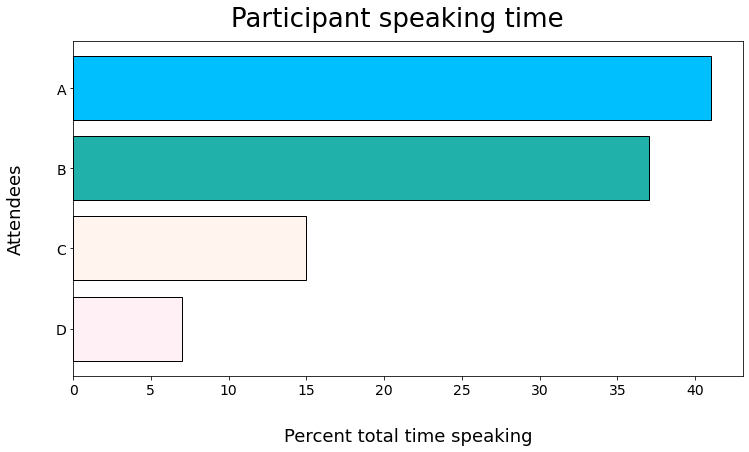

In [93]:
title = "Participant speaking time"
include_names = False
plotTimings( title, timings_ordered_dictionary, include_names )